# Table of Contents

1. [Data Cleaning, Preprocessing and Parametrization](#datacleaning)
3. [SIR Model](#sir)
    1. [Average Betas](#avg)
    2. [Worst Case Scenario](#worst)
    3. [Best Case Scenario](#best)
    4. [Worst Case Scenario with Weighted Betas](#weightedbetas)


In [2]:
#importing necessary packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from scipy.integrate import odeint
import networkx as nx


# Data Cleaning, Preprocessing and Parametrization <a name="datacleaning"></a>

In the following cells we are going to import and pre-process our data. Plus, we will be computing the model parameters. Besides the Betas and Gammas mentioned in the paper, we also tried different weighted procedures using two further inputs: the Derivetives' exposure and the GDP of each country. The aim was to try different weighting procedures, yet we decided to stick to the definition of "ultimate financial risk" explained in the paper. Nevertheless, we kept our computation in this notebook.

The way we computed all the parameters and weights is the following:

- Beta coefficients:

$$β_i= \frac{α_{i}}{\sum_{j=1}^{23}α_{j}}$$

where $α_{ij}$ is the claims exposure of country i towards country j.

- Gamma coefficients:

$$ɣ_i= \frac{1}{101-C_i}$$

where $C_i$ is the numeric risk score attributed to that country: the higher the risk, the higher the recovery time from the crisis.

- Weighted Betas with derivatives

$$β_i= \frac{α_{i}}{\sum_{j=1}^{23}α_{ij}}*w_i$$

where $w_i$ is proportional to the derivative exposure of country i.


- Inverse score: once we computed the normalized weights from the GDP of each country, we computed the inverse score as follows:


$$score_i= \frac{1}{\sum_{j=1}^{23}w_j}$$

where $w_i$ is the normalized GDP ($w_i= \frac{GDP_i}{\sum_{j=1}^{23}GDP_j}$) of country i. The *ratio* is that the higher the GDP, the less risky the country is. Of course those scores are normalized before being used, so that they sum up to 1.

In [6]:
#run this cell to obtain the final dataset

df = pd.read_excel('data/table-b3-s.xlsx')[['Unnamed: 0', 'Foreign Claims', 'Derivatives']].rename(columns = {'Unnamed: 0': 'Country'}).iloc[0:24]
scores = pd.read_excel("data/new credit score.xlsx").rename(columns = {'Unnamed: 0': 'Country'})
countries = []
for i in range(len(scores)):
    countries.append(scores['Country'][i])
    
countries[countries.index('South Korea')] = 'Korea'
scores['Country']=countries

mask = [i in df['Country'].unique() for i in scores['Country']]
scores = scores[mask]

#removing Chinese Taipei from df since there is no corresponding scoring.
df=df.set_index('Country', drop=True)
df = df.drop('Chinese Taipei', axis=0)
assert len(df) == len(scores)
df=df.reset_index(drop=False)

final_df = df.merge(scores, how='inner', left_on='Country', right_on='Country')[['Country', 'Foreign Claims', 'Derivatives', 'Numeric Value']].set_index('Country', drop=True)


#len(countries)

#data cleaning, merging and preprocessing. Skip this cell and run to the next one to directly obtain the final dataset

df_w = pd.read_excel('data/API_NY.GDP.MKTP.CD_DS2_en_excel_v2_935893.xls')
ind = df_w.index[df_w['Country Name'] == 'Korea, Rep.']
df_w.at[ind[0], 'Country Name'] = 'Korea'
df_w=df_w.rename(columns={'GDP ': 'GDP'}).reset_index(drop=True)
df_w.head()

#picking only those 23 countries we are interested in
mask = [i in final_df.index for i in df_w['Country Name']]
df_w = df_w[mask]
df_w = df_w.reset_index(drop=True)



#computing weights

s = df_w['GDP'].sum()
w = []
for i in range(len(df_w)):
    w.append(df_w['GDP'][i]/s)
    
df_w['Weighted scores']=w
df_w = df_w.drop('Weighet score', axis = 1)

#computing inverse scores, since the higher the GDP, the less risky the country is

tmp = []
for i in range(len(df_w)):
    w = 1/df_w['Weighted scores'][i]
    tmp.append(w)
    
df_w['tmp'] = tmp

inv_w = []
s = sum(df_w['tmp'])
for i in range(len(df_w)):
    inv = df_w['tmp'][i]/s
    inv_w.append(inv)

df_w['Inverse score'] = inv_w
df_w = df_w.drop('tmp', axis = 1)

#sum(df_w['Inverse score']) to assert whether it sums up to 1


#merging the final_df with this df_w
df_w = df_w.merge(final_df, left_on = 'Country Name', 
           right_index=True).drop(['GDP', 'Weighted scores'], 
                                  axis = 1).rename(columns = {'Numeric Value': 'Credit Score'})


final_df = df_w.sort_values(by = 'Country Name', ascending = True).reset_index(drop=True)



#computing betas and gammas

betas = []
weighted_betas = [] #weighted by Derivatives
tot_claims = final_df['Foreign Claims'].sum()
tot_derivatives = final_df['Derivatives'].sum()

for i in range(len(final_df)):
      weight = final_df['Derivatives'][i]/tot_derivatives
      num = final_df['Foreign Claims'][i]
      betas.append(num/tot_claims)
      weighted_betas.append((num/tot_claims)*weight)
    
weighted_betas = [float(i)/sum(weighted_betas) for i in weighted_betas]
#sum(weighted_betas)==1.0

gammas = []
for i in range(len(final_df)):
    gammas.append(1/(101-final_df['Credit Score'][i]))
#gammas

final_df['betas'] = betas
final_df['gammas'] = gammas
final_df['weighted betas'] = weighted_betas


#storing results
final_df.to_pickle("final_df.pkl")

,Foreign Claims,Derivatives,Numeric Value
Country,,,
Australia,687.6,55.5,100.0
Austria,391.2,20.4,95.0
Belgium,233.5,32.7,90.0
Canada,1897.9,115.3,100.0
Chile,14.2,2.6,80.0


In [3]:
#run this cell to download results
final_df = pd.read_pickle("final_df.pkl")
final_df

,Country Name,Inverse score,Foreign Claims,Derivatives,Credit Score,betas,gammas,weighted betas
0,Australia,0.019712,687.6,55.5,100.0,0.025719,1.000000,0.006623
1,Austria,0.062082,391.2,20.4,95.0,0.014632,0.166667,0.001385
2,Belgium,0.052077,233.5,32.7,90.0,0.008734,0.090909,0.001325
3,Canada,0.016497,1897.9,115.3,100.0,0.070988,1.000000,0.037976
4,Chile,0.094776,14.2,2.6,80.0,0.000531,0.047619,0.000006
5,Finland,0.102135,472.9,58.3,95.0,0.017688,0.166667,0.004785
6,France,0.010176,3098.6,146.5,90.0,0.115899,0.090909,0.078780
7,Germany,0.007160,1873.4,695.3,100.0,0.070072,1.000000,0.226055
8,Greece,0.129638,57.7,1.0,40.0,0.002158,0.016393,0.000010
9,India,0.010396,85.6,58.9,55.0,0.003202,0.021739,0.000875


Let's inspect the interaction between gammas and betas: we are expecting high betas to correspond to low gammas and vice-versa.

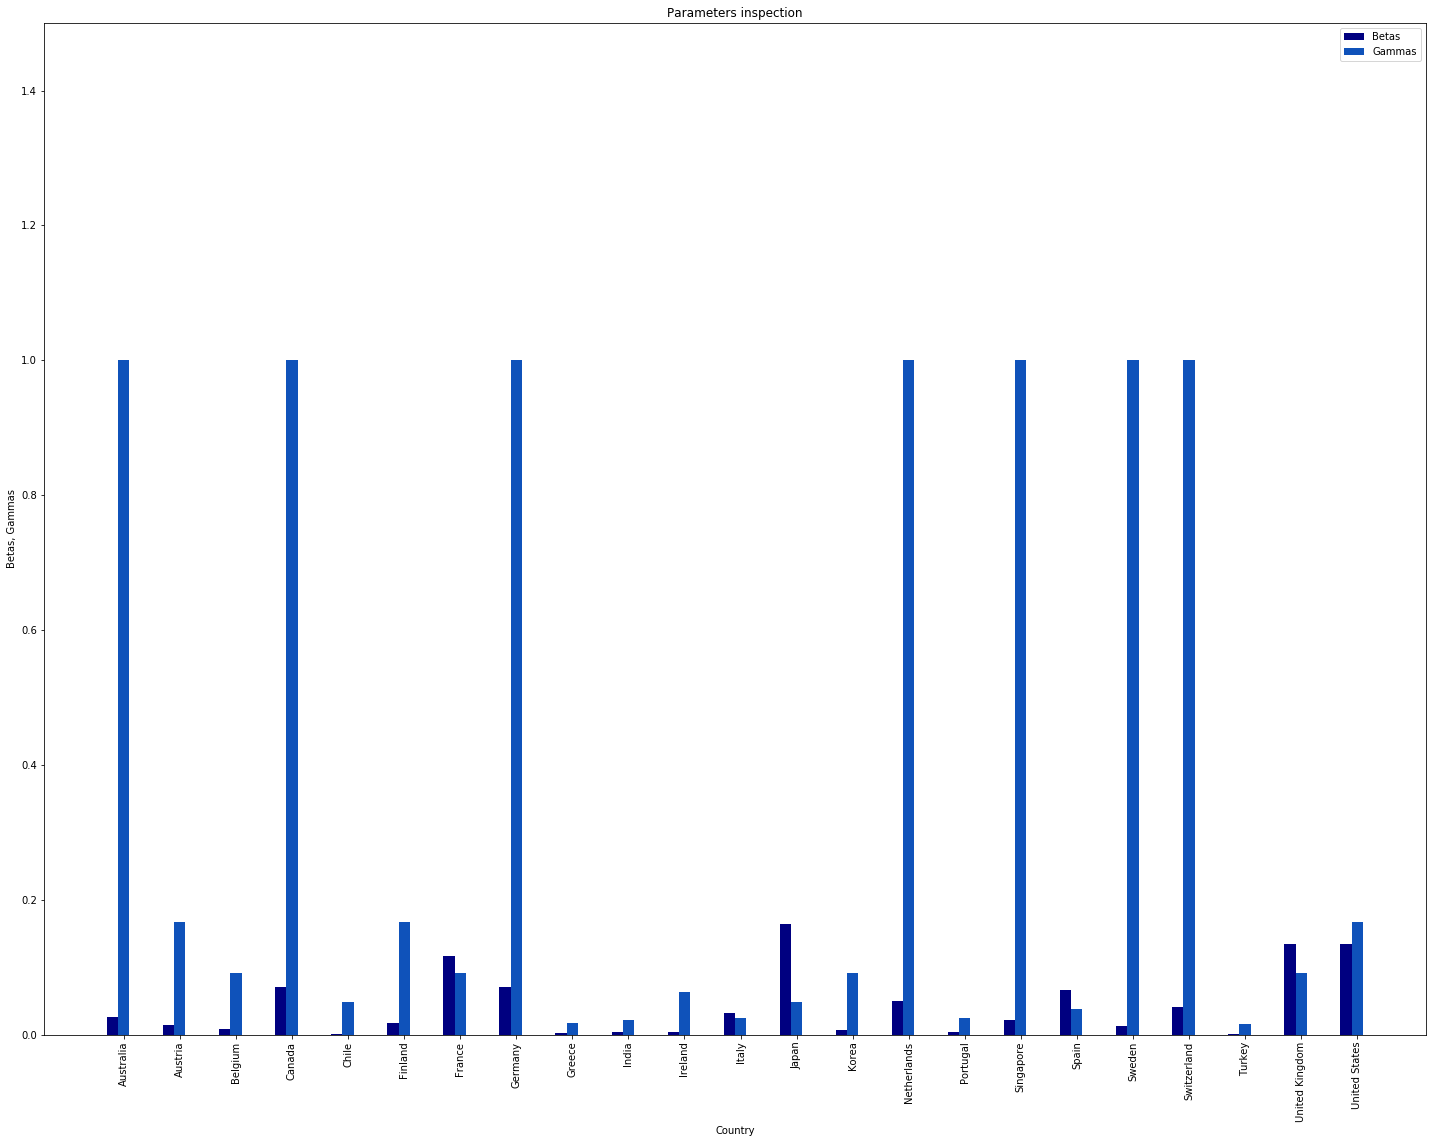

In [14]:
countries = [i for i in final_df['Country Name']]

import numpy as np
import matplotlib.pyplot as plt

data = np.zeros(len(countries)*2).reshape(len(countries), 2)
for i in range(len(final_df)):
    data[i][0] = final_df['betas'][i]
    data[i][1] = final_df['gammas'][i]
    



length = len(countries)
x_labels = countries

# Set plot parameters
fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
width = 0.2 # width of bar
x = np.arange(length)

ax.bar(x, data[:,0], width, color='#000080', label='Betas')
ax.bar(x + width, data[:,1], width, color='#0F52BA', label='Gammas')


ax.set_ylabel('Betas, Gammas')
ax.set_ylim(0,1.5)
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Country')
ax.set_title('Parameters inspection')
ax.legend()
#plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.xticks(rotation='vertical')
plt.show()

# 2. SIR MODEL <a name="sir"></a>

In this section, we explore some scenarios with the compartmental model SIR. With this purpose, we used the following differential equations:

\begin{eqnarray}
\frac{\partial S_t}{\partial t} =  - \beta\frac{I_t}{N_t} S_t\\
\frac{\partial I_t}{\partial t} = \beta\frac{I_t}{N_t} S_t - \gamma I_t\\
\frac{\partial R_t}{\partial t} = \gamma I_t\\
\end{eqnarray}

With betas and gammas being the averages, maxima or minima of the parameters computed above.
In addition, we will also try the weighted betas approach using weights proportional to the derivatived exposure.

In [3]:
#initializing lists of betas and gammas
betas = list(final_df['betas'])
gammas = list(final_df['gammas'])
weighted_betas = list(final_df['weighted betas'])

In [4]:
class SIR_model:
    def __init__(self, INPUT, beta:float, gamma:float , ndays:int , steps_per_day:int):
        
        """
        :params:
        INPUT: S , I , R  initial number of countries
        beta: probability of transmitting the crisis when a country has an exposure with an infected one
        gamma:  1 / average duration of crisis     
        nt: number of time steps (day /month /year) you want to run the simulation
        steps_per_t: number of step per each time unit
        """
        
        # INITIALIZE POPULATION
        self.INPUT = INPUT

        # INITIALIZE PARAMETERS
        self.beta = beta 
        self.gamma = gamma

        self.R0 = self.beta / self.gamma 
        print('Basic reproductive number (Ro): {}'.format((round(self.R0,3)))) 

        # DEFINE TIME VARIABLE 
        self.time_step = 1/ steps_per_day   
        self.t = np.arange(0, ndays+1, self.time_step) 
        
    def SIR_eq(self,INPUT,t, beta, gamma):
    
        """
        :returns:
        variations of the sistem dS,dI,dR 
        """
        S, I, R = INPUT  
        N = S + I + R
        
        dS_dt =  - (beta * S * (I / N)) 
        dI_dt =    (beta * S * (I / N)) - (gamma * I)
        dR_dt =    (gamma * I)
        
        return dS_dt, dI_dt, dR_dt
    
    def run(self):  
        """
        :returns:
        List of population over time. 
        Each element of the list represent the population size at a given time step. 
        """ 
        
        RES = odeint(self.SIR_eq, self.INPUT, self.t, args=(self.beta,self.gamma))
        self.SRES, self.IRES, self.RRES  = RES.T

        print('\nPopulation in {} days:'.format(int(self.t[-1])))
        print('Susceptibles: {}'.format(round(self.SRES[-1], 3)))
        print('Infected: {}'.format(round(self.IRES[-1], 3)))
        print('Recovered: {}'.format(round(self.RRES[-1], 3)))

        return self.SRES, self.IRES, self.RRES
      


## A. Average Betas and Gammas <a name="avg"></a>

Basic reproductive number (Ro): 0.123

Population in 20 days:
Susceptibles: 19.646
Infected: 0.005
Recovered: 3.348
R_0:  0.12252048294549868
Beta:  0.04347826086956521
Gamma:  0.3548652423195706


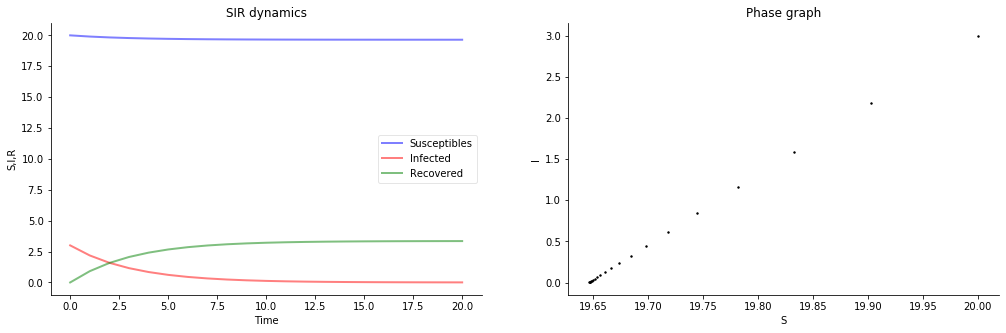

In [5]:
"""
Experiment 1: average non-weighted betas 

"""
# Define time variables: 
ndays = 20
steps_per_day = 1

# INITIALIZE PARAMETERS
gamma = np.average(gammas)   
beta = np.average(betas)   # averaging across the 23 betas
r_0 = beta/gamma

# INITIALIZE POPULATION
N = 23 # population size
I0 = 3   # intial n° of infected countries 
R0 = 0
S0 = N - I0 -R0


# Initial conditions vector
y0 = S0 , I0, R0

#print("basic reproductive number: ", r_0)

SIR_ex1 = SIR_model(y0, beta,gamma, ndays, steps_per_day) 
S, I , R  = SIR_ex1.run()


# PLOT
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))

ax = axs[0]
ax.set_title('SIR dynamics')

ax.plot(SIR_ex1.t, S, 'b', alpha=0.5, lw=2, label= 'Susceptibles')
ax.plot(SIR_ex1.t, I, 'r', alpha=0.5, lw=2, label= 'Infected')
ax.plot(SIR_ex1.t, R, 'g', alpha=0.5, lw=2, label= 'Recovered')

ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)


ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(S, I ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')


for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)


print("R_0: ", r_0)
print("Beta: ", beta)
print("Gamma: ", gamma)

## B. Worst Case Scenario <a name="worst"></a>

basic reproductive number:  10.792387620907112
Basic reproductive number (Ro): 10.792

Population in 100 days:
Susceptibles: 0.013
Infected: 7.098
Recovered: 15.889


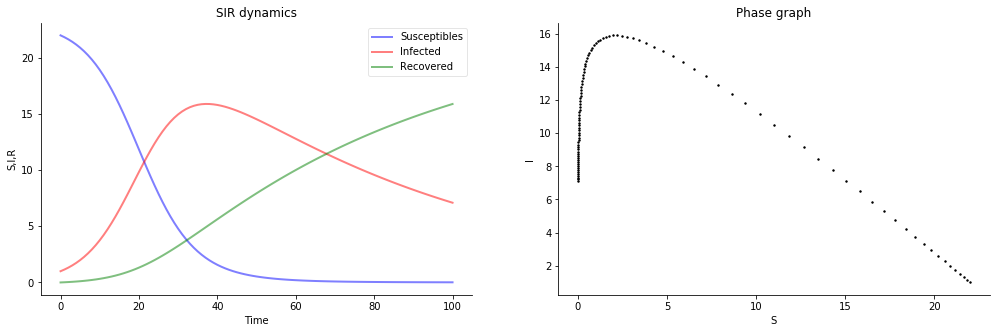

In [6]:
"""
Experiment 2: worst case scenario, taking the highest values for betas and lowest for gammas

"""
# Define time variables: 
ndays = 100
steps_per_day = 1

# INITIALIZE PARAMETERS
gamma = np.min(gammas)   
beta = np.max(betas)   # averaging across the 23 betas
r_0 = beta/gamma

# INITIALIZE POPULATION
N = 23 # population size
I0 = 1   # intial n° of infected countries 
R0 = 0
S0 = N - I0 -R0


# Initial conditions vector
y0 = S0, I0, R0

print("basic reproductive number: ", r_0)

SIR_ex1 = SIR_model(y0, beta,gamma, ndays, steps_per_day) 
S, I , R  = SIR_ex1.run()


# PLOT
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))

ax = axs[0]
ax.set_title('SIR dynamics')

ax.plot(SIR_ex1.t, S, 'b', alpha=0.5, lw=2, label= 'Susceptibles')
ax.plot(SIR_ex1.t, I, 'r', alpha=0.5, lw=2, label= 'Infected')
ax.plot(SIR_ex1.t, R, 'g', alpha=0.5, lw=2, label= 'Recovered')

ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)


ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(S, I ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')


for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

## C. Best Case Scenario <a name="best"></a>

Even with only one initially infected country, the virus spreads very quickly

basic reproductive number:  0.0005311310098221832
Basic reproductive number (Ro): 0.001

Population in 100 days:
Susceptibles: 21.999
Infected: -0.0
Recovered: 1.001


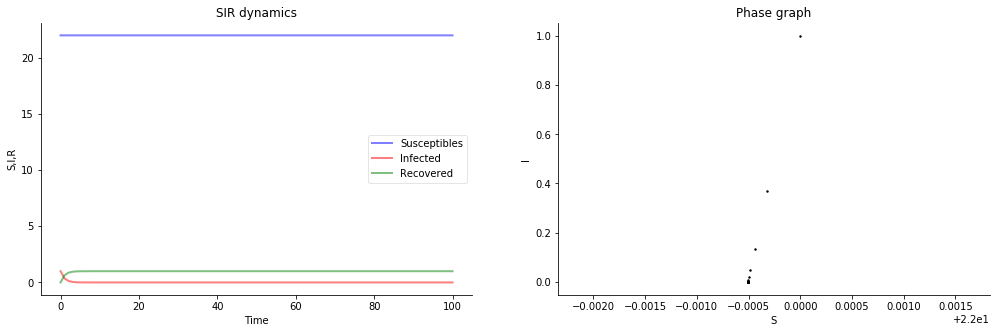

In [7]:
"""
Experiment 3: best case scenario, taking the highest values for gammas and lowest for betas 

"""
# Define time variables: 
ndays = 100
steps_per_day = 1

# INITIALIZE PARAMETERS
gamma = np.max(gammas)   
beta = np.min(betas)   # averaging across the 23 betas
r_0 = beta/gamma

# INITIALIZE POPULATION
N = 23 # population size
I0 = 1   # intial n° of infected countries 
R0 = 0
S0 = N - I0 -R0


# Initial conditions vector
y0 = S0 , I0, R0

print("basic reproductive number: ", r_0)

SIR_ex1 = SIR_model(y0, beta,gamma, ndays, steps_per_day) 
S, I , R  = SIR_ex1.run()


# PLOT
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))

ax = axs[0]
ax.set_title('SIR dynamics')

ax.plot(SIR_ex1.t, S, 'b', alpha=0.5, lw=2, label= 'Susceptibles')
ax.plot(SIR_ex1.t, I, 'r', alpha=0.5, lw=2, label= 'Infected')
ax.plot(SIR_ex1.t, R, 'g', alpha=0.5, lw=2, label= 'Recovered')

ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)


ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(S, I ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')


for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

## D. Worst Case Scenario with Weighted Betas <a name="weightedbetas"></a>

basic reproductive number:  20.203697355381237
Basic reproductive number (Ro): 20.204

Population in 100 days:
Susceptibles: 0.0
Infected: 5.979
Recovered: 17.021


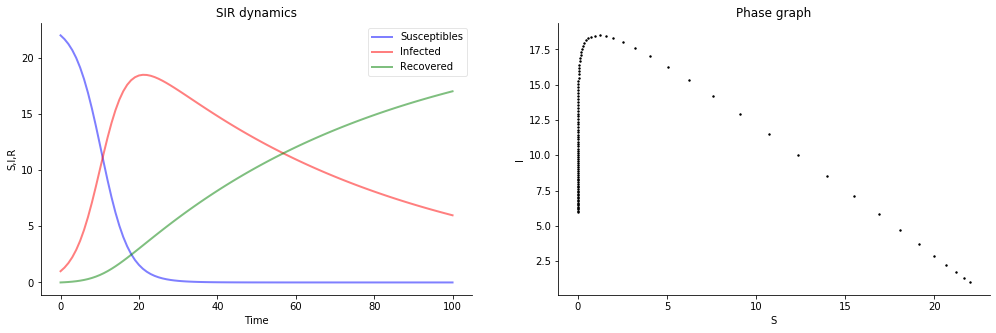

In [8]:
"""
Experiment 3: worst case scenario, taking the lowest values for gammas and highest for weighted betas 

"""
# Define time variables: 
ndays = 100
steps_per_day = 1

# INITIALIZE PARAMETERS
gamma = np.min(gammas)   
beta = np.max(weighted_betas)   # averaging across the 23 betas
r_0 = beta/gamma

# INITIALIZE POPULATION
N = 23 # population size
I0 = 1   # intial n° of infected countries 
R0 = 0
S0 = N - I0 -R0


# Initial conditions vector
y0 = S0 , I0, R0

print("basic reproductive number: ", r_0)

SIR_ex1 = SIR_model(y0, beta,gamma, ndays, steps_per_day) 
S, I , R  = SIR_ex1.run()


# PLOT
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))

ax = axs[0]
ax.set_title('SIR dynamics')

ax.plot(SIR_ex1.t, S, 'b', alpha=0.5, lw=2, label= 'Susceptibles')
ax.plot(SIR_ex1.t, I, 'r', alpha=0.5, lw=2, label= 'Infected')
ax.plot(SIR_ex1.t, R, 'g', alpha=0.5, lw=2, label= 'Recovered')

ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)


ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(S, I ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')


for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)